In [254]:
import serial.tools.list_ports
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import sys
from IPython.display import display, clear_output

# Live Reading

In [255]:
# List available ports and print them for user reference
ports = list(serial.tools.list_ports.comports())
print("Available ports:")
for port in ports:
    print(port.device)

Available ports:
COM5


In [256]:


# User settings
serial_port = "COM5"
baud_rate = 115200
window_size = 1000  # Number of samples to show on the plot
refresh_rate = 1000  # Update plot every this many samples
vmax = 5.0  # Full-scale voltage (reference)
components = 'x'  # 'x' for single channel, 'xy' for two-channel data

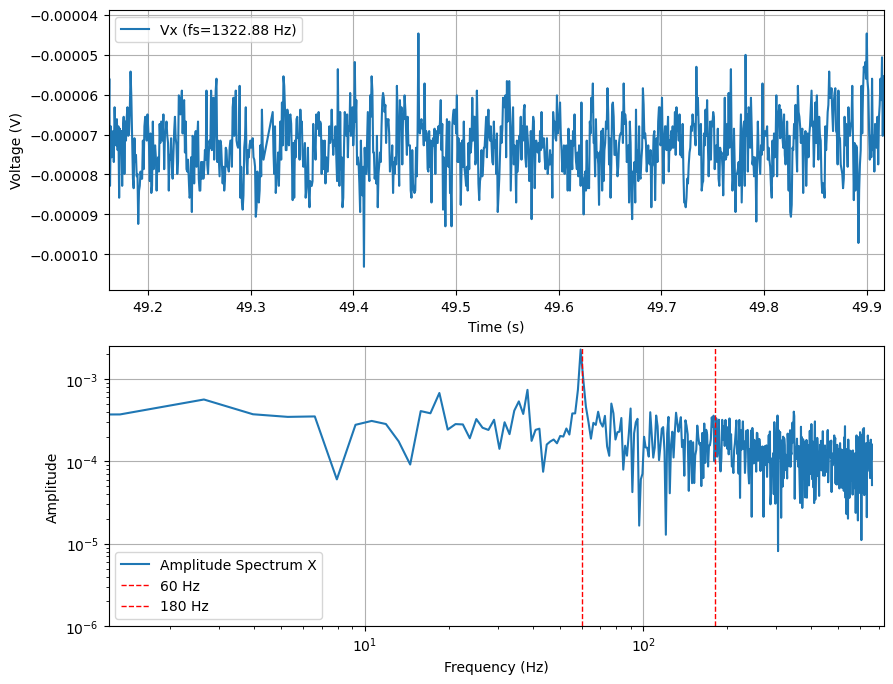

Plotting stopped by user.


AttributeError: 'tuple' object has no attribute 'tb_frame'

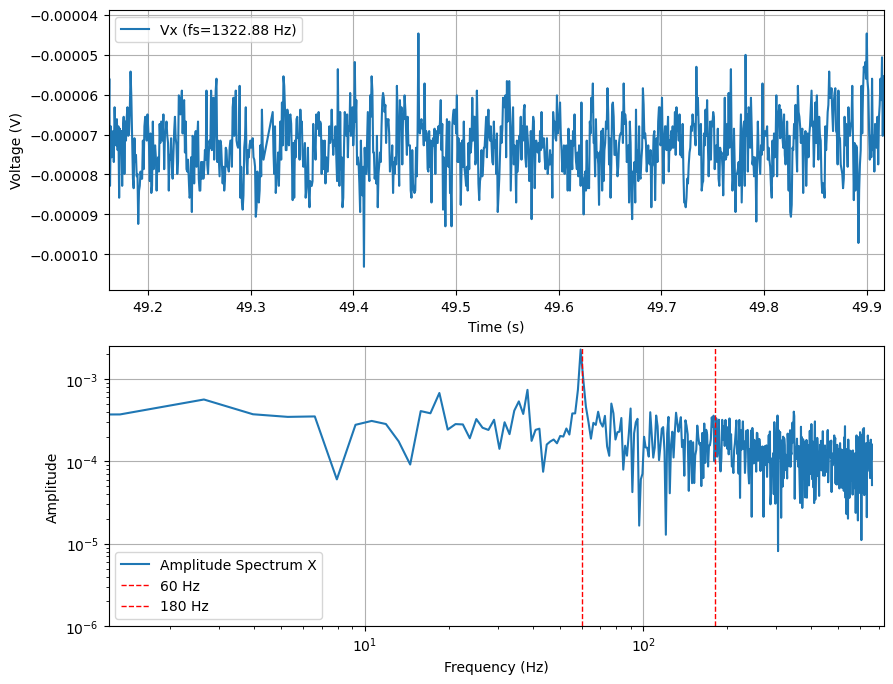

In [257]:


# Margin factors for axes
time_domain_margin_factor = 0.1
fft_margin_factor = 1.1

# Initialize data buffers
V_data_x = deque([0.0] * window_size, maxlen=window_size)
t_data_x = deque([0.0] * window_size, maxlen=window_size)

if components == 'xy':
    V_data_y = deque([0.0] * window_size, maxlen=window_size)
    t_data_y = deque([0.0] * window_size, maxlen=window_size)

# Initialize plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

line_x, = ax1.plot([], [], label="Vx")
if components == 'xy':
    line_y, = ax1.plot([], [], label="Vy")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V)")
ax1.grid(True)
ax1.legend()

fft_line_x, = ax2.plot([], [], label="Amplitude Spectrum X")
if components == 'xy':
    fft_line_y, = ax2.plot([], [], label="Amplitude Spectrum Y")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Amplitude")
ax2.axvline(60, color="red", linestyle="--", linewidth=1, label="60 Hz")
ax2.axvline(180, color="red", linestyle="--", linewidth=1, label="180 Hz")
ax2.grid(True)
ax2.legend()

def try_connect(serial_port, baud_rate):
    while True:
        try:
            ser_conn = serial.Serial(serial_port, baud_rate, timeout=1)
            print(f"Connected to {serial_port}")
            return ser_conn
        except (serial.SerialException, OSError):
            print(f"Waiting for device on {serial_port}...")
            time.sleep(1)

def compute_fft(y_data, t_data):
    """Compute FFT amplitude spectrum of given data y_data with corresponding time t_data,
    by resampling to a uniform grid using the average sampling interval."""
    if len(y_data) < 2:
        return None, None, None
    
    time_array = np.array(t_data)
    y_array = np.array(y_data)
    
    dt_array = np.diff(time_array)
    mean_dt = np.mean(dt_array)
    if mean_dt <= 0:
        return None, None, None

    t_min = time_array[0]
    t_max = time_array[-1]
    t_uniform = np.arange(t_min, t_max, mean_dt)
    if len(t_uniform) < 2:
        return None, None, None

    # Interpolate y_data onto t_uniform
    y_uniform = np.interp(t_uniform, time_array, y_array)

    fs = 1.0 / mean_dt
    Y = np.fft.rfft(y_uniform - np.mean(y_uniform))  # Remove DC offset
    freqs = np.fft.rfftfreq(len(y_uniform), d=1.0/fs)
    # Compute amplitude (not power)
    A = np.abs(Y)
    return freqs, A, mean_dt

def update_plot():
    # Update time-domain data
    line_x.set_xdata(t_data_x)
    line_x.set_ydata(V_data_x)
    
    if components == 'xy':
        line_y.set_xdata(t_data_y)
        line_y.set_ydata(V_data_y)

    # Adjust the time domain plot limits based on actual data
    min_v = min(V_data_x) if len(V_data_x) > 0 else -vmax
    max_v = max(V_data_x) if len(V_data_x) > 0 else vmax

    if components == 'xy' and len(V_data_y) > 0:
        min_v = min(min_v, min(V_data_y))
        max_v = max(max_v, max(V_data_y))

    if len(t_data_x) > 1:
        ax1.set_xlim(min(t_data_x), max(t_data_x))

    if min_v == max_v:
        min_v -= 0.1
        max_v += 0.1

    v_range = max_v - min_v
    min_v -= v_range * time_domain_margin_factor
    max_v += v_range * time_domain_margin_factor

    ax1.set_ylim(min_v, max_v)

    # Compute FFT for X
    freqs_x, A_x, mean_dt_x = compute_fft(V_data_x, t_data_x)
    have_fft_x = (freqs_x is not None and A_x is not None and len(freqs_x) > 1)
    fs_x = 1.0 / mean_dt_x if mean_dt_x else None

    if have_fft_x:
        fft_line_x.set_xdata(freqs_x)
        fft_line_x.set_ydata(A_x)
        if fs_x:
            line_x.set_label(f"Vx (fs={fs_x:.2f} Hz)")

    # Compute FFT for Y if needed
    have_fft_y = False
    fs_y = None
    if components == 'xy':
        freqs_y, A_y, mean_dt_y = compute_fft(V_data_y, t_data_y)
        have_fft_y = (freqs_y is not None and A_y is not None and len(freqs_y) > 1)
        if mean_dt_y:
            fs_y = 1.0 / mean_dt_y
        if have_fft_y:
            fft_line_y.set_xdata(freqs_y)
            fft_line_y.set_ydata(A_y)
            if fs_y:
                line_y.set_label(f"Vy (fs={fs_y:.2f} Hz)")

    # Determine FFT axis limits
    if have_fft_x:
        # Frequency limits from X data
        fmin = freqs_x[1] if len(freqs_x) > 1 else 0.1
        fmax = freqs_x[-1] if len(freqs_x) > 0 else 1000

        # Amplitude limits from X
        A_min_data = np.min(A_x)
        A_max_data = np.max(A_x)

        # Include Y data if present
        if have_fft_y:
            fmax = max(fmax, freqs_y[-1])
            A_min_data = min(A_min_data, np.min(A_y))
            A_max_data = max(A_max_data, np.max(A_y))

        # If min and max are equal, spread them slightly
        if A_min_data == A_max_data:
            A_min_data -= 1e-6
            A_max_data += 1e-6

        # Apply margin factors
        fmin = max(fmin / fft_margin_factor, 0.1) 
        fmax = fmax * fft_margin_factor
        A_min = A_min_data / fft_margin_factor
        A_max = A_max_data * fft_margin_factor

        # Ensure A_min and A_max are positive and not zero (since log scale)
        if A_min <= 0:
            A_min = max(A_max * 1e-6, 1e-9)  # A small positive number
        if A_max <= A_min:
            A_max = A_min * 10.0

        ax2.set_xlim(fmin, fmax)
        A_min = 1e-6 # quick dirty make plot better
        ax2.set_ylim(A_min, A_max)
    else:
        # No FFT data
        # Set some reasonable default range if no data at all
        ax2.set_xlim(0.1, 1e3)
        ax2.set_ylim(1e-9, 1e-1)

    ax1.legend()
    ax2.legend()

    clear_output(wait=True)
    display(fig)


try:
    ser = try_connect(serial_port, baud_rate)
    sample_count = 0

    while True:
        try:
            if ser.in_waiting:
                data_chunk = ser.read(ser.in_waiting).decode("utf-8", errors='replace')
                lines = data_chunk.splitlines()

                for line in lines:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        data = line.split(",")

                        if components == 'x':
                            voltage_x = float(data[0])
                            timestamp_us = float(data[1])
                            voltage_x = voltage_x / (2**23) * vmax
                            timestamp_x = timestamp_us * 1e-6
                            V_data_x.append(voltage_x)
                            t_data_x.append(timestamp_x)

                        elif components == 'xy':
                            voltage_x = float(data[0])
                            timestamp_x_us = float(data[1])
                            voltage_y = float(data[2])
                            timestamp_y_us = float(data[3])

                            voltage_x = voltage_x / (2**23) * vmax
                            voltage_y = voltage_y / (2**23) * vmax
                            timestamp_x = timestamp_x_us * 1e-6
                            timestamp_y = timestamp_y_us * 1e-6

                            V_data_x.append(voltage_x)
                            t_data_x.append(timestamp_x)
                            V_data_y.append(voltage_y)
                            t_data_y.append(timestamp_y)

                        sample_count += 1
                        if sample_count % refresh_rate == 0:
                            update_plot()

                    except (ValueError, IndexError):
                        pass

        except (serial.SerialException, OSError):
            print("Device disconnected. Attempting to reconnect...")
            ser.close()
            ser = try_connect(serial_port, baud_rate)

except KeyboardInterrupt:
    print("Plotting stopped by user.")
    sys.exit(0)

finally:
    if 'ser' in locals() and ser.is_open:
        ser.close()
